# Fit Convergent Cross Mapping Model to Data Sets

In [234]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

np.seterr(divide='ignore', invalid='ignore')


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [235]:
# from 2012-2020 9 years in total, 12 months for each year
merged_df = pd.read_csv('./data/merged_data.csv',index_col=0)
merged_df = merged_df.sort_values(by=['year','month'],ascending=[True, True])
merged_df.shape

(4428, 10)

In [236]:
merged_df.head()

,USstate,year,month,nTweets_x,nTweets_y,Number of establishments (ESTAB),full,population,actual_rape_total,cost_of_living_index
0,ga,2012,1,162945.0,5.0,843.0,Georgia,9986384,186,77.770000
108,nj,2012,1,17721.0,2.0,1656.0,New Jersey,8925939,83,84.134292
324,md,2012,1,25993.0,1.0,1168.0,Maryland,6067471,84,84.071647
432,tx,2012,1,105604.0,6.0,1910.0,Texas,26143479,628,68.166168
540,az,2012,1,62231.0,1.0,208.0,Arizona,6572455,205,74.997196


### Part A: Check the data on statewise

In [237]:
state_list = list(set(merged_df['USstate'].to_list()))
print(len(state_list))

41


#### Cost of living data

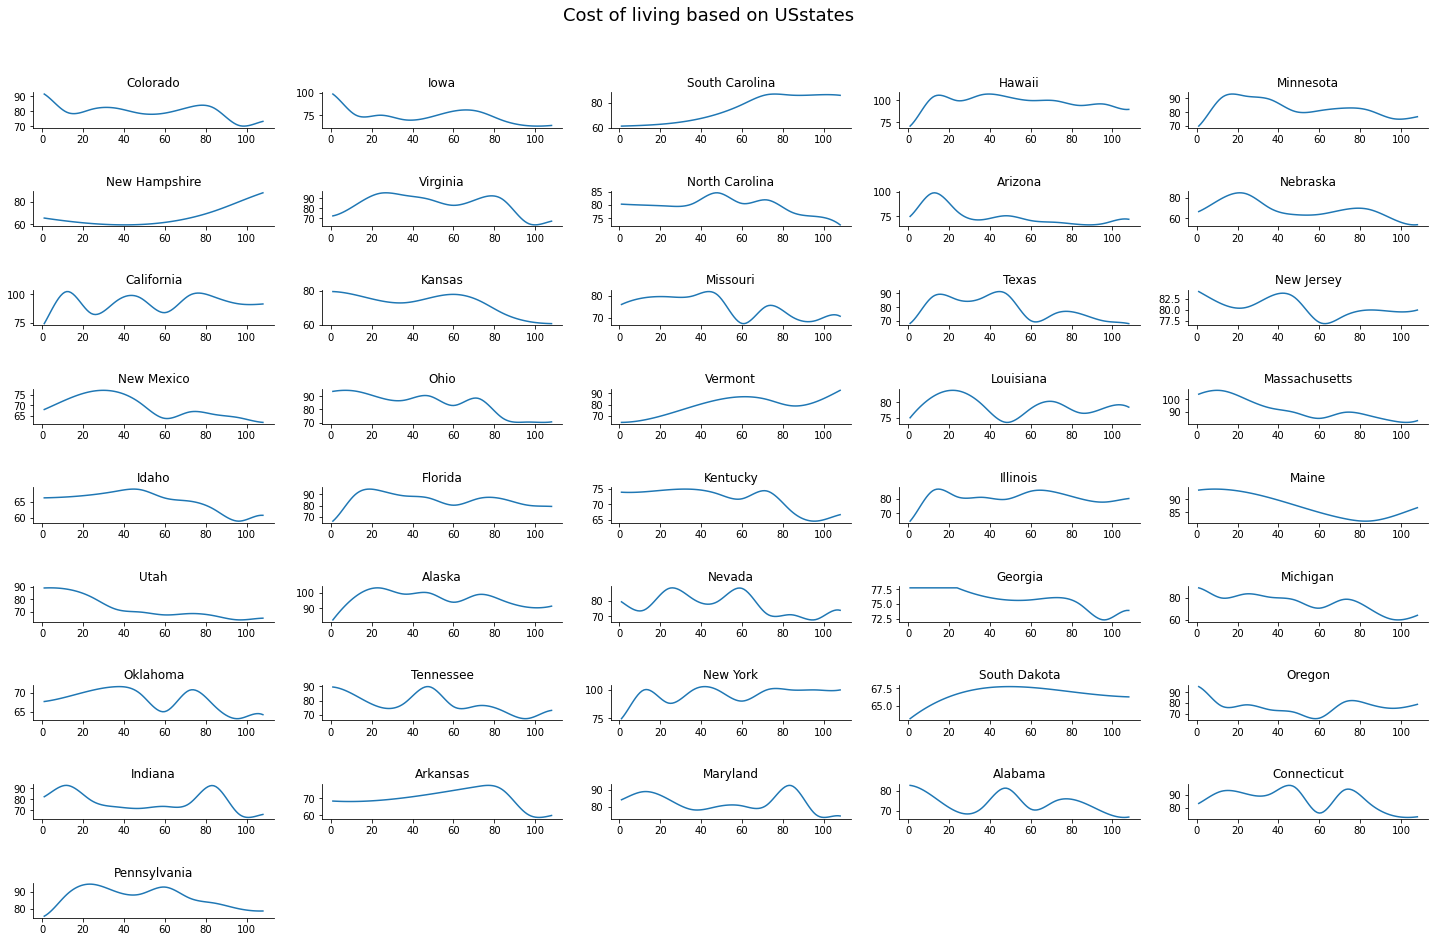

In [238]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Cost of living based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    x1_cost_of_living = data['cost_of_living_index'].to_numpy()
    

    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109),x1_cost_of_living)
    ax.set_title(curr_state)
    sns.despine()

### Step 2. Fit the CCM model

#### (1) Crime data VS Cost of living

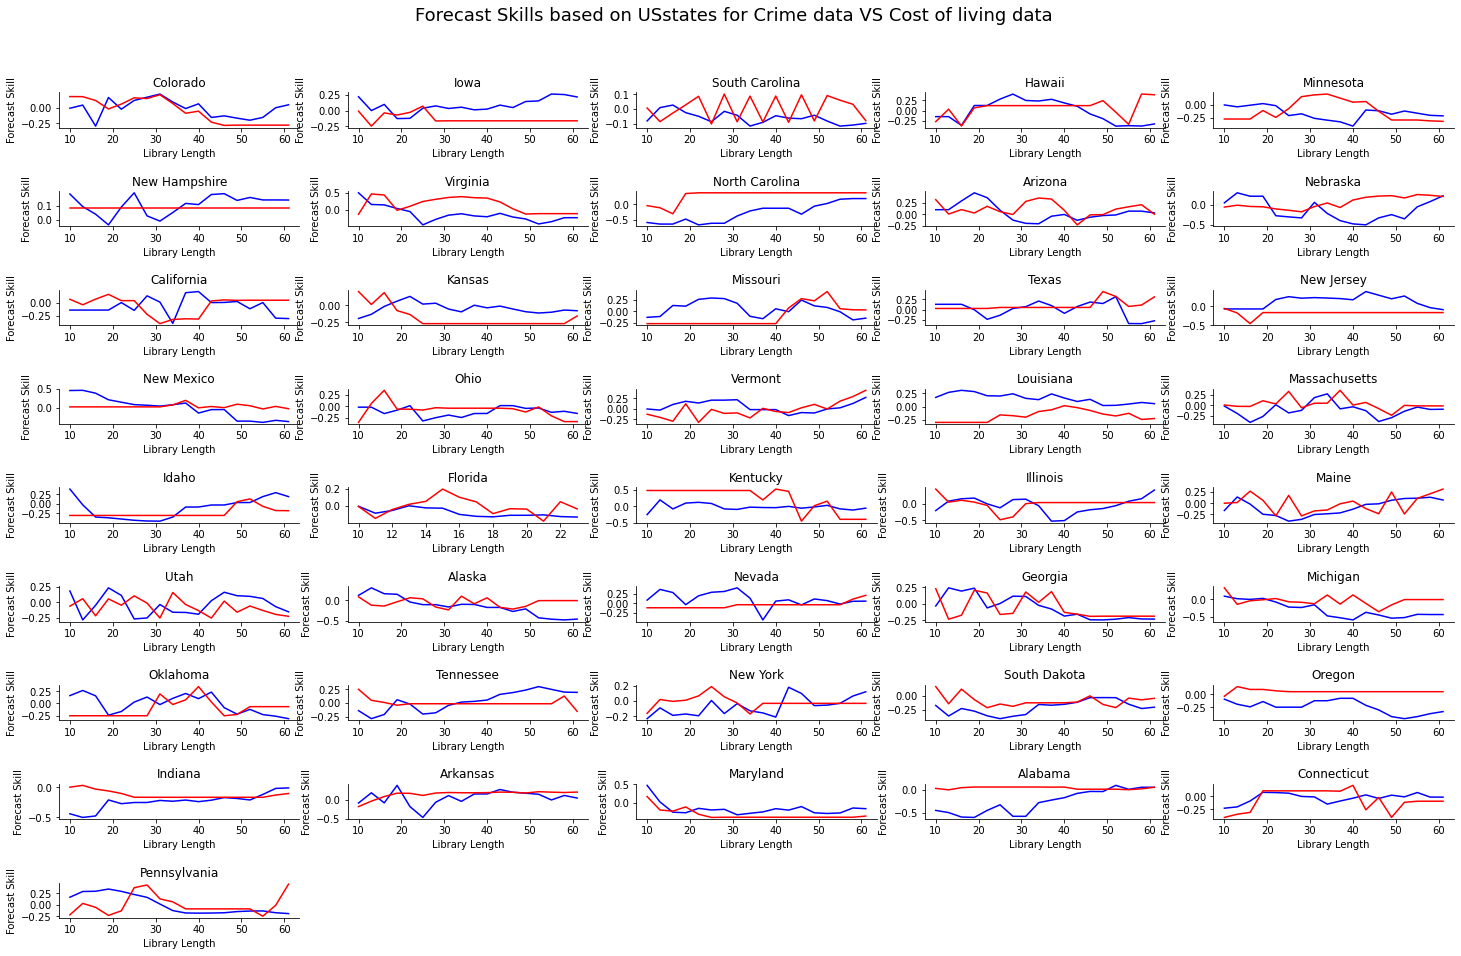

In [239]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Skills based on USstates for Crime data VS Cost of living data", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_cost_of_living = data['cost_of_living_index'].to_numpy()
    x2_crime = data['actual_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_cost_of_living)
    e2 = ccm.Embed(x2_crime)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

#### (2). Shifted Crime VS Cost of living

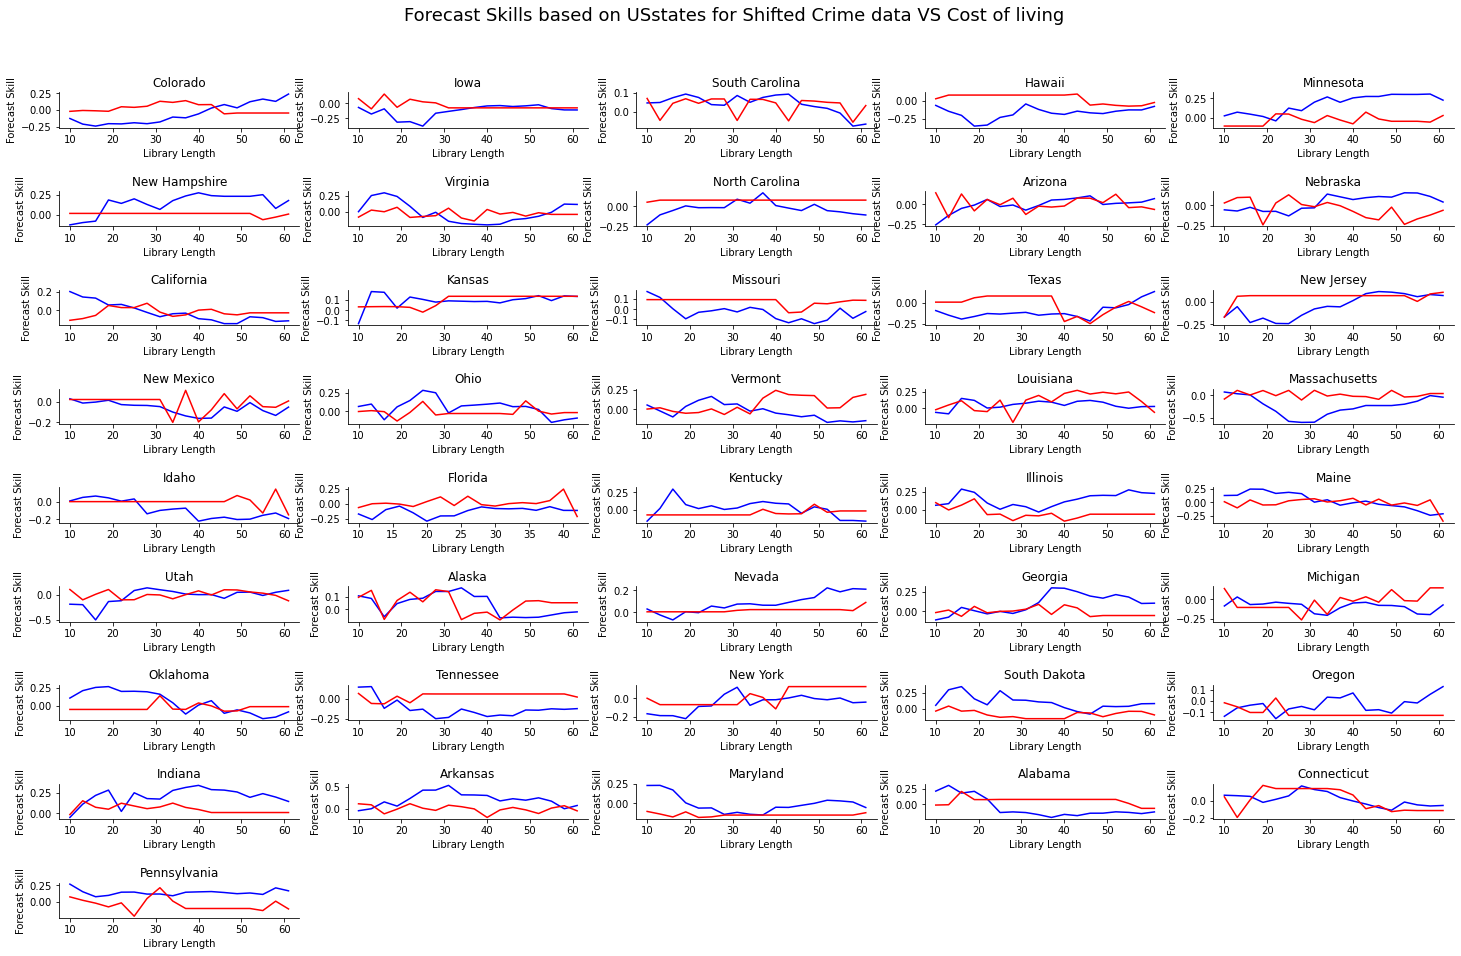

In [240]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Skills based on USstates for Shifted Crime data VS Cost of living", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['shifted_rape_total'] = data['actual_rape_total'] - data['actual_rape_total'].shift(-1)
    data['shifted_rape_total'] = data['shifted_rape_total'].fillna(0)
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_cost_of_living = data["cost_of_living_index"].to_numpy()
    x2_rape_total = data['shifted_rape_total'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_cost_of_living)
    e2 = ccm.Embed(x2_rape_total)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_rape_total, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

#### (3) Tweets VS Cost of living

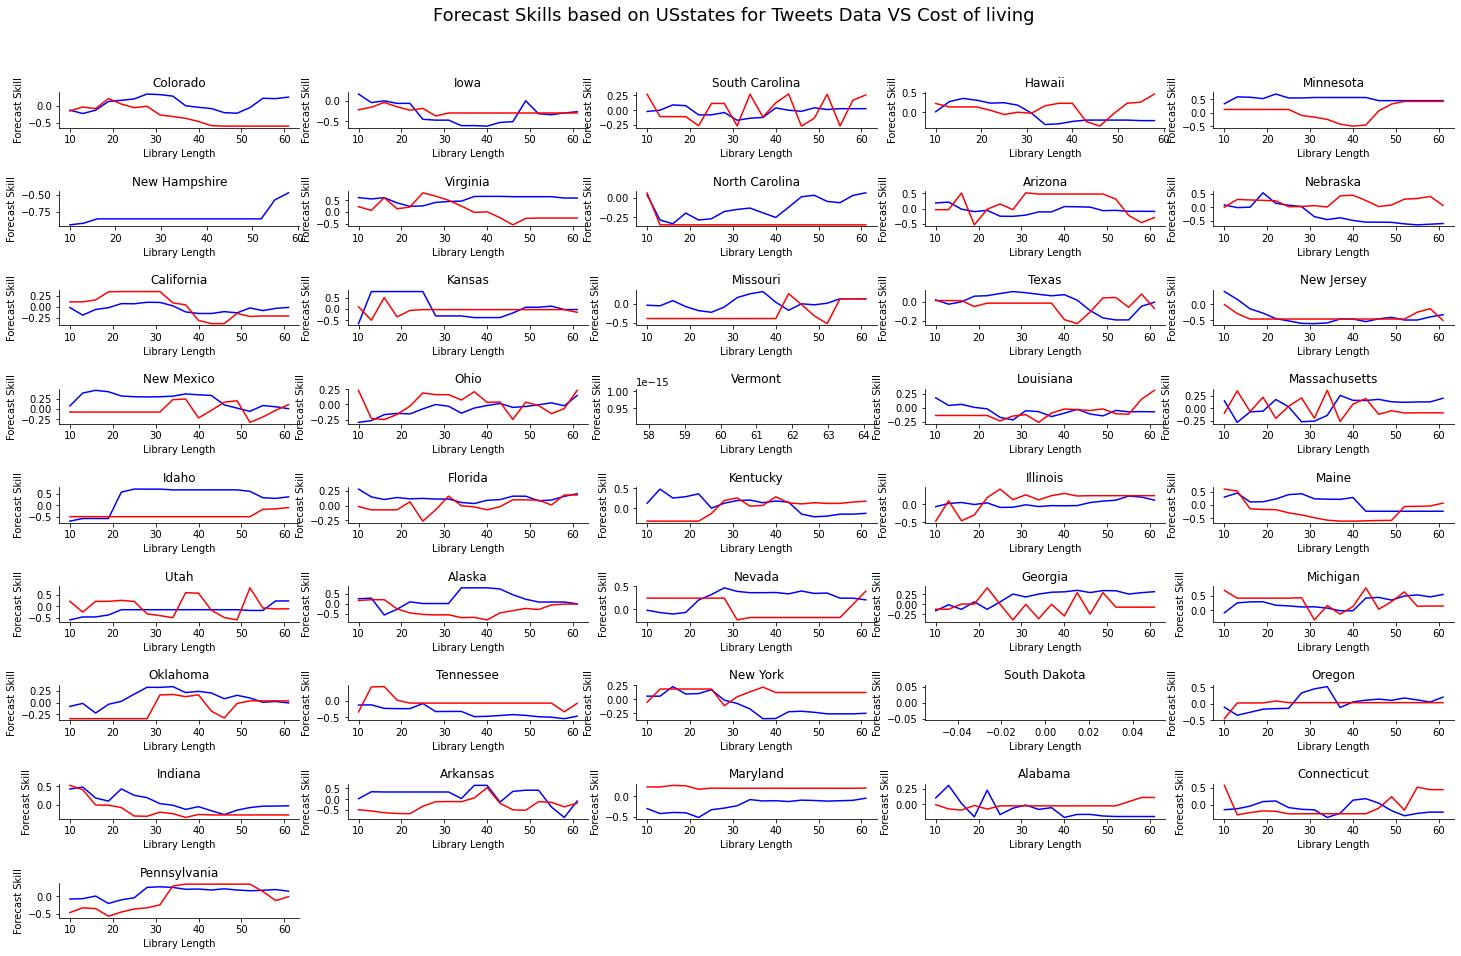

In [241]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Skills based on USstates for Tweets Data VS Cost of living", fontsize=18, y=0.95)

for i in range(len(state_list)):
    data = merged_df[merged_df['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    
    # 0. extract data
    x1_cost_of_living = data["cost_of_living_index"].to_numpy()
    x2_tweet = data['misogyny_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_cost_of_living)
    e2 = ccm.Embed(x2_tweet)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_tweet, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict tweets
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

### Part B: base on the countrywise

In [242]:
merged_data_use = merged_df.copy()
merged_data_use['misogyny_proportion'] = merged_data_use['nTweets_y'] / merged_data_use['nTweets_x']
merged_data_use = merged_data_use.groupby(['year','month']).sum()
merged_data_use['shifted_rape_total'] = merged_data_use['actual_rape_total'] - merged_data_use['actual_rape_total'].shift(-1)
merged_data_use['shifted_rape_total'] = merged_data_use['shifted_rape_total'].fillna(0)
merged_data_use
#merged_data_use = merged_data_use.drop(columns=['nTweets_x','nTweets_y','population','Number of establishments (ESTAB)'])

merged_data_use = merged_data_use[['cost_of_living_index', 'misogyny_proportion','actual_rape_total', 'shifted_rape_total']]
merged_data_use

cost_of_living_index  misogyny_proportion  actual_rape_total  \
year month                                                                 
2012 1               3186.833179             0.003657               5846   
     2               3206.180004             0.003209               5349   
     3               3226.909380             0.003085               6240   
     4               3248.521511             0.003574               5811   
     5               3270.516604             0.003604               6080   
...                          ...                  ...                ...   
2020 8               3018.820727             0.001829               9331   
     9               3025.160965             0.001852               8866   
     10              3031.471365             0.001854               8408   
     11              3037.418122             0.001852               7519   
     12              3042.667427             0.001884              14191   

            shifted_rape_total  
year month                      
2012 1                   497.0  
     2                  -891.0  
     3                   429.0  
     4                  -269.0  
     5                  -953.0  
...                        ...  
2020 8                   465.0  
     9                   458.0  
     10                  889.0  
     11                -6672.0  
     12                    0.0  

[108 rows x 4 columns]

### 1. Extract data

In [243]:
x1_cost_of_living = merged_data_use['cost_of_living_index'].to_numpy()
x2_crime = merged_data_use['actual_rape_total'].to_numpy()
x3_tweet = merged_data_use['misogyny_proportion'].to_numpy()
x4_shifted_crime = merged_data_use['shifted_rape_total'].to_numpy()

Text(0.5, 0, 'time series')

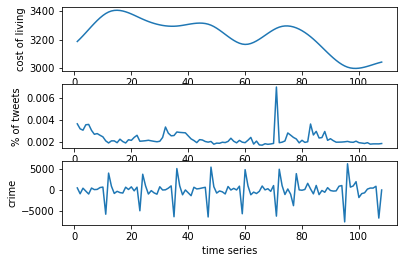

In [244]:
fig,ax = plt.subplots(nrows=3,sharex=False,sharey=False)

ax[0].plot(np.arange(1,109),x1_cost_of_living)
#ax[1].plot(np.arange(1,109),x2_crime)#
ax[1].plot(np.arange(1,109),x3_tweet)
ax[2].plot(np.arange(1,109),x4_shifted_crime)
ax[0].set_ylabel("cost of living")
ax[1].set_ylabel("% of tweets")
ax[2].set_ylabel("crime")
# ax[0].set_title("cost of living index")
# ax[1].set_title("% of tweets ")
# ax[2].set_title("crime")

ax[2].set_xlabel("time series")


Text(0.5, 1.0, 'Cost of living index based on US country')

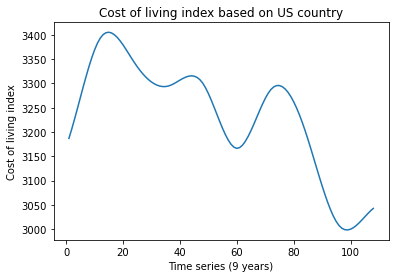

In [245]:
plt.plot(np.arange(1,109),x1_cost_of_living)
plt.xlabel("Time series (9 years)")
plt.ylabel("Cost of living index")
plt.title("Cost of living index based on US country")

In [246]:
corr = merged_data_use.corr()         # reference correlation
corr

,cost_of_living_index,misogyny_proportion,actual_rape_total,shifted_rape_total
cost_of_living_index,1.000000,0.169475,-0.268137,0.015112
misogyny_proportion,0.169475,1.000000,-0.236940,-0.182564
actual_rape_total,-0.268137,-0.236940,1.000000,0.535238
shifted_rape_total,0.015112,-0.182564,0.535238,1.000000


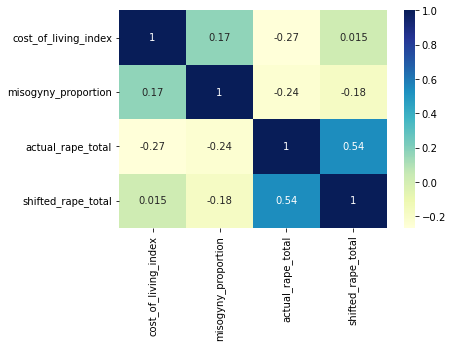

In [247]:
dataplot = sns.heatmap(corr,cmap="YlGnBu", annot=True)

### 2. cost of living against crime

#### (1) Calculate Mutual information

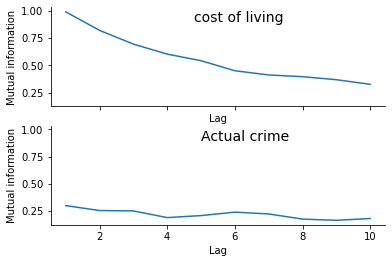

In [248]:
e1 = ccm.Embed(x1_cost_of_living)
e2 = ccm.Embed(x2_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Mutual information')
ax[0].annotate("cost of living", xy=(4.8, 0.9), color = "black", fontsize = 14)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Mutual information')
ax[1].annotate("Actual crime", xy=(5, 0.9), color = "black", fontsize = 14)

sns.despine()

#### (2). Embed the time series

9


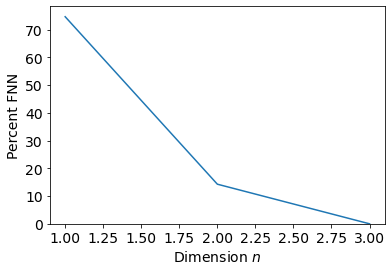

FNN embedding Dimension:  3


In [249]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x2_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

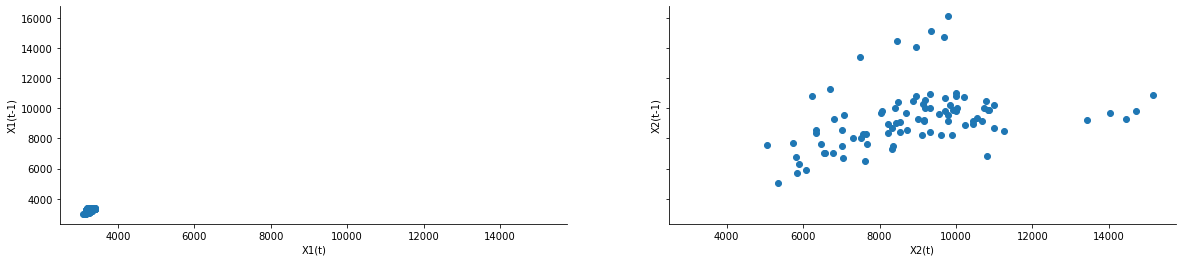

In [250]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

#### (3). Forecast skill as a function of library length

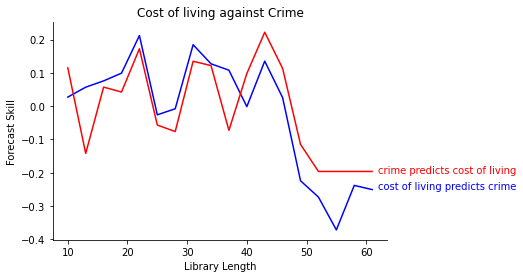

In [251]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # cost of living predict crime

ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict cost of living
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
ax.set_title("Cost of living against Crime")
plt.annotate("crime predicts cost of living", xy=(62, -0.2), color = "red")
plt.annotate("cost of living predicts crime", xy=(62, -0.25), color = "blue")
sns.despine()

### 3. cost of living VS Shifted Crime 

#### (1). Calculate Mutual information

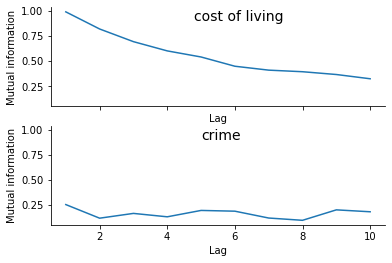

In [252]:
e1 = ccm.Embed(x1_cost_of_living)
e2 = ccm.Embed(x4_shifted_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Mutual information')
ax[0].annotate("cost of living", xy=(4.8, 0.9), color = "black", fontsize = 14)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Mutual information')
ax[1].annotate("crime", xy=(5, 0.9), color = "black", fontsize = 14)
sns.despine()

#### (2). Embed the time series

9


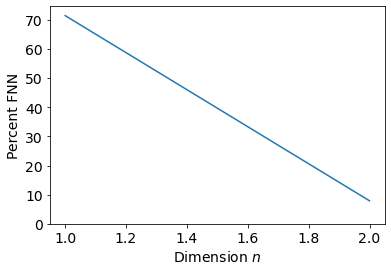

FNN embedding Dimension:  2


In [253]:
from pickle import FALSE


min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)


perc_FNN, embed = FNN_n(x4_shifted_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

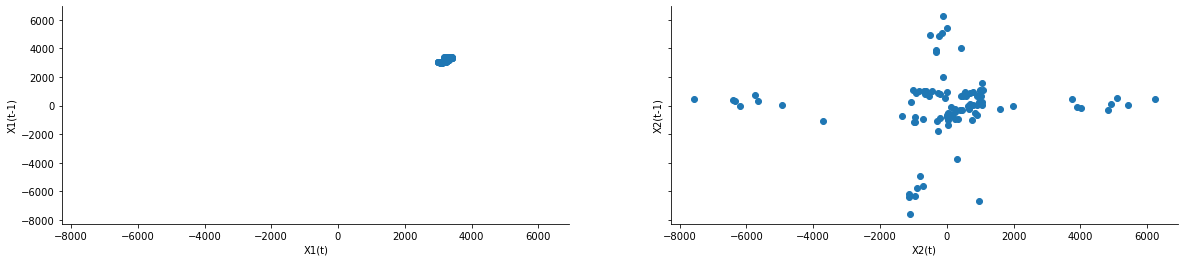

In [254]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

#### (3). Forecast skill as a function of library length

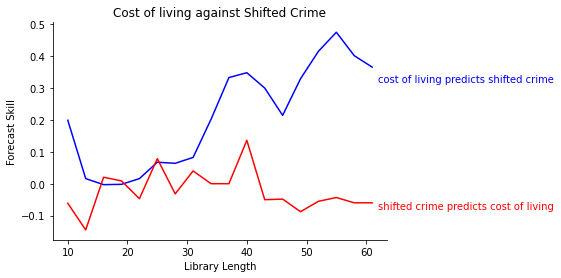

In [255]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # cost of living predict shifted crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # shifted crime predict cost of living 
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
ax.set_title("Cost of living against Shifted Crime")
plt.annotate("shifted crime predicts cost of living", xy=(62, -0.08), color = "red")
plt.annotate("cost of living predicts shifted crime", xy=(62, 0.32), color = "blue")
sns.despine()

### 4. cost of living against misogyny tweets

#### (1). Calculate Mutual information

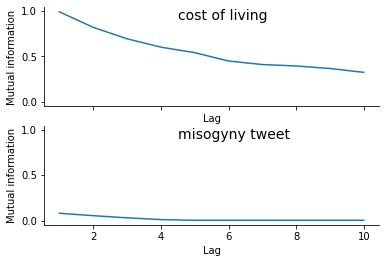

In [256]:
e1 = ccm.Embed(x1_cost_of_living)
e2 = ccm.Embed(x3_tweet)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Mutual information')
ax[0].annotate("cost of living", xy=(4.5, 0.9), color = "black", fontsize = 14)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Mutual information')
ax[1].annotate("misogyny tweet", xy=(4.5, 0.9), color = "black", fontsize = 14)
sns.despine()

#### (2). Embed the time series

9


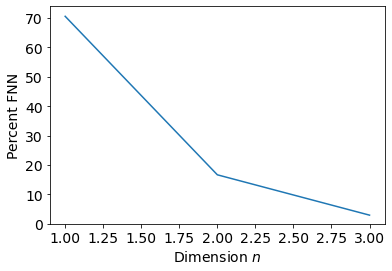

FNN embedding Dimension:  3


In [257]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

perc_FNN, embed = FNN_n(x3_tweet, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

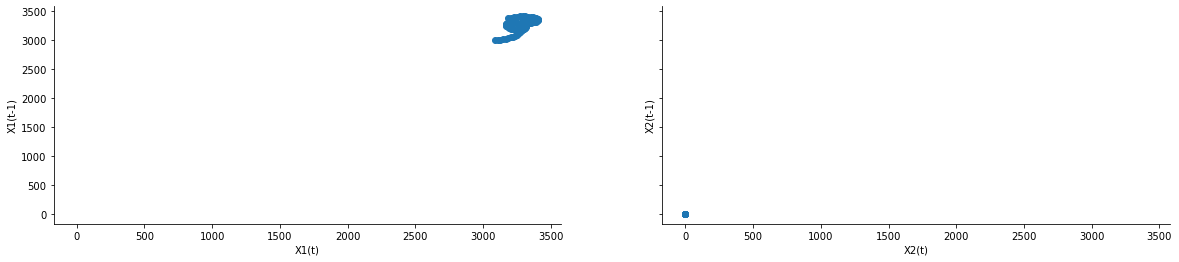

In [258]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

#### (3). Forecast skill as a function of library length

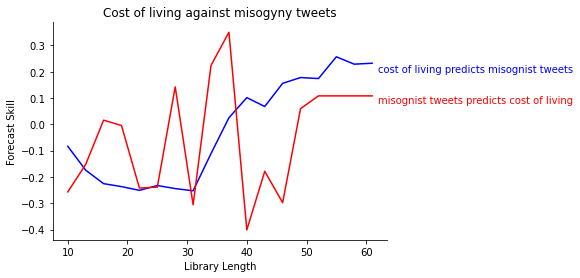

In [259]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

# plot
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # cost of living predict tweets
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # tweets predict cost of living
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
ax.set_title("Cost of living against misogyny tweets")
plt.annotate("misognist tweets predicts cost of living", xy=(62, 0.08), color = "red")
plt.annotate("cost of living predicts misognist tweets", xy=(62, 0.2), color = "blue")
sns.despine()